# 00_Data_processing


Objective: 

    - Download A.oryzae genome
    - Parse through
    - Retrieve signal peptides
    - plot

In [1]:
from Bio import SeqIO
import pandas as pd
from Bio.Seq import Seq

In [2]:
path_to_file = '../data/00_All_proteins_and_partitions_Aoryzae/FungiDB-59_AoryzaeRIB40_AnnotatedProteins.fasta'  

# Open file with "with" statement to avoid problems with access 
proteins = []

with open(path_to_file, mode='r') as handle:
    for record in SeqIO.parse(handle, 'fasta'):

        # Extract individual parts of the FASTA record
        identifier = record.id
        description = record.description
        sequence = record.seq
        # append
        proteins.append(record)

In [3]:
proteins[0].seq

Seq('MLISSVAKDGYGKDIWTLPFDSITRILKFTWLLQLLYIPALAATKMAFLCLYLR...RSR')

In [4]:
len(proteins)

12090

In [5]:
### Partitioning the proteins into 5000 long fasta files

In [6]:
partition1 = proteins[0:5000]
len(partition1)

5000

In [7]:
partition2 = proteins[5000:10000]
len(partition2)

5000

In [8]:
partition3 = proteins[10000:]
len(partition3)


2090

In [9]:
all_partitions = [[partition1]+[partition2]+[partition3]]
all_partitions = [partition1+partition2+partition3]

len(all_partitions)

1

In [10]:
with open(f"../data/00_All_protein_partitions_Aoryzae/partition1.fasta", "w") as output_handle:
    SeqIO.write(partition1, output_handle, "fasta")
with open(f"../data/00_All_protein_partitions_Aoryzae/partition2.fasta", "w") as output_handle:
    SeqIO.write(partition2, output_handle, "fasta")
with open(f"../data/00_All_protein_partitions_Aoryzae/partition3.fasta", "w") as output_handle:
    SeqIO.write(partition3, output_handle, "fasta")

These partitions have been sent to SignalP and run on their servers. 

### Examining SignalP output


gff files are just a text file. So we can parse it like a normal text file:

In [11]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord


def open_gff3_files(path:str= ''):
    with open(path, 'r') as infile:
        LINES = []
        for line in infile:
            LINES.append(line[:].split('\t'))
        LINES = LINES[1:]
    
    return LINES


def tidy_up_gff(lst_of_gff:list):
    signal_peptides = {}
    list_of_peptides = []

    for peptide in lst_of_gff:
        signal_peptides['gene'] = peptide[0][:19]
        signal_peptides['start_pos'] = int(peptide[3])-1
        signal_peptides['end_pos']= int(peptide[4])-1
        signal_peptides['signal_peptide_likelyhood']= peptide[5]
        list_of_peptides.append(signal_peptides)
        signal_peptides = {'gene':'', 'start_pos':'', 'end_pos':'','signal_peptide_likelyhood': '' }

    return list_of_peptides



def dict_of_signal_peptides(path:str= ''):
    gff = open_gff3_files(path)
    dict_of_signal_peptides = tidy_up_gff(gff)

    return dict_of_signal_peptides


def read_gff_to_pd(path:str= ''): 
    
    gff = open_gff3_files(path)
    dict_of_signal_peptides = tidy_up_gff(gff)
    df = pd.DataFrame.from_records(dict_of_signal_peptides)
    
    return df




def read_gff_to_pd(path:str= ''): 
    
    gff = open_gff3_files(path)
    dict_of_signal_peptides = tidy_up_gff(gff)
    df = pd.DataFrame.from_records(dict_of_signal_peptides)
    
    return df

def cross_ref_with_genome(list_of_peptides:list ,all_proteins:list ):
    
    signal_peptide_seqs = []
    pure_sequences = []

    for signal_peptide in list_of_peptides:
        for seqrecord in all_proteins:
            if signal_peptide['gene'] in seqrecord.id:             
                seq = SeqRecord(
                    Seq(seqrecord.seq[signal_peptide['start_pos']:signal_peptide['end_pos']]), 

                    id=seqrecord.id,
                    name=seqrecord.name,
                    description="signal_peptide predicted by signalP")


                signal_peptide_seqs.append(seq)
                pure_sequences.append(str(seqrecord.seq[signal_peptide['start_pos']:signal_peptide['end_pos']]))


    return pure_sequences

In [12]:
partition1_signal_peptides = read_gff_to_pd('../data/01-SignalP_output/Partition1/output.gff3')
partition2_signal_peptides = read_gff_to_pd('../data/01-SignalP_output/Partition2/output (1).gff3')
partition3_signal_peptides = read_gff_to_pd('../data/01-SignalP_output/Partition3/output (2).gff3')


all_signal_peptides_df = pd.concat([partition1_signal_peptides, partition2_signal_peptides, partition3_signal_peptides])
all_signal_peptides_df

,gene,start_pos,end_pos,signal_peptide_likelyhood
0,AO090005000016-T-p1,0,23,0.99980325
1,AO090005000029-T-p1,0,23,0.99983543
2,AO090005000042-T-p1,0,23,0.99984324
3,AO090005000053-T-p1,0,41,0.8548089
4,AO090005000059-T-p1,0,18,0.9998212
...,...,...,...,...
196,AO090103000483-T-p1,0,19,0.83310604
197,AO090103000487-T-p1,0,19,0.99971014
198,AO090103000493-T-p1,0,17,0.99979144
199,AO090701000994-T-p1,0,18,0.99984515


In [13]:
partition1_signal_peptides = dict_of_signal_peptides('../data/01-SignalP_output/Partition1/output.gff3')
partition2_signal_peptides = dict_of_signal_peptides('../data/01-SignalP_output/Partition2/output (1).gff3')
partition3_signal_peptides = dict_of_signal_peptides('../data/01-SignalP_output/Partition3/output (2).gff3')
all_signal_peptides = partition1_signal_peptides +partition2_signal_peptides+ partition3_signal_peptides

In [14]:
pure_signal_peptide = cross_ref_with_genome(all_signal_peptides, proteins)
pure_signal_peptide[0]

'MAPSHSFMLFLSVICTHLCSLVV'

In [15]:
all_signal_peptides_df['sequence'] = pure_signal_peptide
all_signal_peptides_df

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence
0,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV
1,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD
2,AO090005000042-T-p1,0,23,0.99984324,MKASFISRLLSLTAFAISSNLSY
3,AO090005000053-T-p1,0,41,0.8548089,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVAL
4,AO090005000059-T-p1,0,18,0.9998212,MHLQATLAVGLSLLGLTL
...,...,...,...,...,...
196,AO090103000483-T-p1,0,19,0.83310604,MKTSFLLAAIGFLYRLPCS
197,AO090103000487-T-p1,0,19,0.99971014,MTRYLSFLFLLILFGNSVF
198,AO090103000493-T-p1,0,17,0.99979144,MRGIVALSFLSVALGVT
199,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ


In [16]:
list_of_SPs = list(all_signal_peptides_df['sequence'])

Lets write all the motifs to a csv file:

In [17]:
with open('../data/all_signal_peptides/all_SPs.txt', 'w') as outhandle: 
    for i in range(len(list_of_SPs)): 
        outhandle.write('>'+str(i)+'\n'+list_of_SPs[i]+'\n')

In [18]:
### Statistics on lenght: 
mean_length = all_signal_peptides_df["end_pos"].mean()
mean_length 


21.388312912346844

In [19]:
### Statistics on lenght: 
median = all_signal_peptides_df["end_pos"].median()
median 

20.0

In [20]:
### Statistics on lenght: 
describe = all_signal_peptides_df["end_pos"].describe()
describe 

count    1061.000000
mean       21.388313
std         6.170687
min        12.000000
25%        18.000000
50%        20.000000
75%        24.000000
max        68.000000
Name: end_pos, dtype: float64

Lets get the differenct regions of the signal peptides: 

##  Regions of Signal peptides

In [21]:
partition1_signal_peptides_regions = read_gff_to_pd('../data/01-SignalP_output/Partition1/region_output.gff3')
partition2_signal_peptides_regions = read_gff_to_pd('../data/01-SignalP_output/Partition2/region_output (1).gff3')
partition3_signal_peptides_regions = read_gff_to_pd('../data/01-SignalP_output/Partition3/region_output (2).gff3')


In [22]:
all_signal_peptide_regions = pd.concat([partition1_signal_peptides_regions,partition2_signal_peptides_regions,partition3_signal_peptides_regions])
all_signal_peptide_regions.columns = ['gene',	'start_pos_region','end_pos_region','region']
all_signal_peptide_regions

,gene,start_pos_region,end_pos_region,region
0,AO090005000016-T-p1,0,3,.
1,AO090005000016-T-p1,4,20,.
2,AO090005000016-T-p1,21,23,.
3,AO090005000029-T-p1,0,1,.
4,AO090005000029-T-p1,2,12,.
...,...,...,...,...
598,AO090701000994-T-p1,2,12,.
599,AO090701000994-T-p1,13,18,.
600,AO090701001287-T-p1,0,2,.
601,AO090701001287-T-p1,3,17,.


In [23]:
(len(all_signal_peptide_regions)/3)

1061.0

In [24]:
# every region is the same N, H, C. will just append a long list 
regions = ['n-region', 'h-region', 'c-region']* int((len(all_signal_peptide_regions)/3))
all_signal_peptide_regions['region'] = regions

In [25]:
merged = pd.merge(all_signal_peptides_df,all_signal_peptide_regions , on=["gene"])
merged

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,start_pos_region,end_pos_region,region
0,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,0,3,n-region
1,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,4,20,h-region
2,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,21,23,c-region
3,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,0,1,n-region
4,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,2,12,h-region
...,...,...,...,...,...,...,...,...
3178,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ,2,12,h-region
3179,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ,13,18,c-region
3180,AO090701001287-T-p1,0,21,0.99986553,MLFYRAFGGLLCFLYACVTVS,0,2,n-region
3181,AO090701001287-T-p1,0,21,0.99986553,MLFYRAFGGLLCFLYACVTVS,3,17,h-region


In [26]:
merged['region_seq'] = ''

In [27]:
list_of_seqs = []
for index, row in merged.iterrows():
    start = int(row['start_pos_region'])
    stop = int(row['end_pos_region'])
    list_of_seqs.append(row['sequence'][start:stop])
    
merged['region_seq'] = list_of_seqs

### Biochemical analysis

In [28]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis



list_of_kyle_d = []
isoelectric_point =[]
charge = []

for index, row in merged.iterrows():
    protein = ProteinAnalysis(row['region_seq'])
    list_of_kyle_d.append(protein.gravy())
    isoelectric_point.append(protein.isoelectric_point())
    charge.append(protein.charge_at_pH(7))

    
    
merged['Kyte_Doolittle_hydrophobicity'] = list_of_kyle_d
merged['isoelectric_point'] = isoelectric_point
merged['charge_at_ph7'] = charge




In [29]:
merged

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,start_pos_region,end_pos_region,region,region_seq,Kyte_Doolittle_hydrophobicity,isoelectric_point,charge_at_ph7
0,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,0,3,n-region,MAP,0.700000,5.275022,-0.499645
1,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,4,20,h-region,HSFMLFLSVICTHLCS,1.443750,6.898344,-0.085352
2,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,21,23,c-region,VV,4.200000,5.494989,-0.266012
3,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,0,1,n-region,M,1.900000,5.275022,-0.499645
4,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,2,12,h-region,LRNIVIALAA,1.820000,9.750021,0.760092
...,...,...,...,...,...,...,...,...,...,...,...,...
3178,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ,2,12,h-region,LLLIAPLFSA,2.370000,5.525000,-0.239898
3179,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ,13,18,c-region,SYGAQ,-0.840000,5.239782,-0.540853
3180,AO090701001287-T-p1,0,21,0.99986553,MLFYRAFGGLLCFLYACVTVS,0,2,n-region,ML,2.850000,5.275022,-0.499645
3181,AO090701001287-T-p1,0,21,0.99986553,MLFYRAFGGLLCFLYACVTVS,3,17,h-region,YRAFGGLLCFLYAC,1.264286,8.045155,0.738292


### grouping the regions 

In [30]:
n_region = merged.groupby("region")
n_region = n_region.get_group('n-region')


h_region = merged.groupby("region")
h_region = h_region.get_group('h-region')


c_region = merged.groupby("region")
c_region = c_region.get_group('c-region')

In [31]:
c_region

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,start_pos_region,end_pos_region,region,region_seq,Kyte_Doolittle_hydrophobicity,isoelectric_point,charge_at_ph7
2,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,21,23,c-region,VV,4.200000,5.494989,-0.266012
5,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,13,23,c-region,AVASPVDLQD,0.290000,4.050028,-2.198703
8,AO090005000042-T-p1,0,23,0.99984324,MKASFISRLLSLTAFAISSNLSY,21,23,c-region,SY,-1.050000,5.239782,-0.540853
11,AO090005000053-T-p1,0,41,0.8548089,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVAL,36,41,c-region,PTVAL,1.500000,5.954987,-0.041471
14,AO090005000059-T-p1,0,18,0.9998212,MHLQATLAVGLSLLGLTL,16,18,c-region,TL,1.550000,5.184989,-0.601803
...,...,...,...,...,...,...,...,...,...,...,...,...
3170,AO090103000483-T-p1,0,19,0.83310604,MKTSFLLAAIGFLYRLPCS,16,19,c-region,PCS,0.033333,5.909914,-0.051372
3173,AO090103000487-T-p1,0,19,0.99971014,MTRYLSFLFLLILFGNSVF,14,19,c-region,GNSVF,0.460000,5.525000,-0.239898
3176,AO090103000493-T-p1,0,17,0.99979144,MRGIVALSFLSVALGVT,14,17,c-region,GVT,1.033333,5.525000,-0.239898
3179,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ,13,18,c-region,SYGAQ,-0.840000,5.239782,-0.540853


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'c-region')

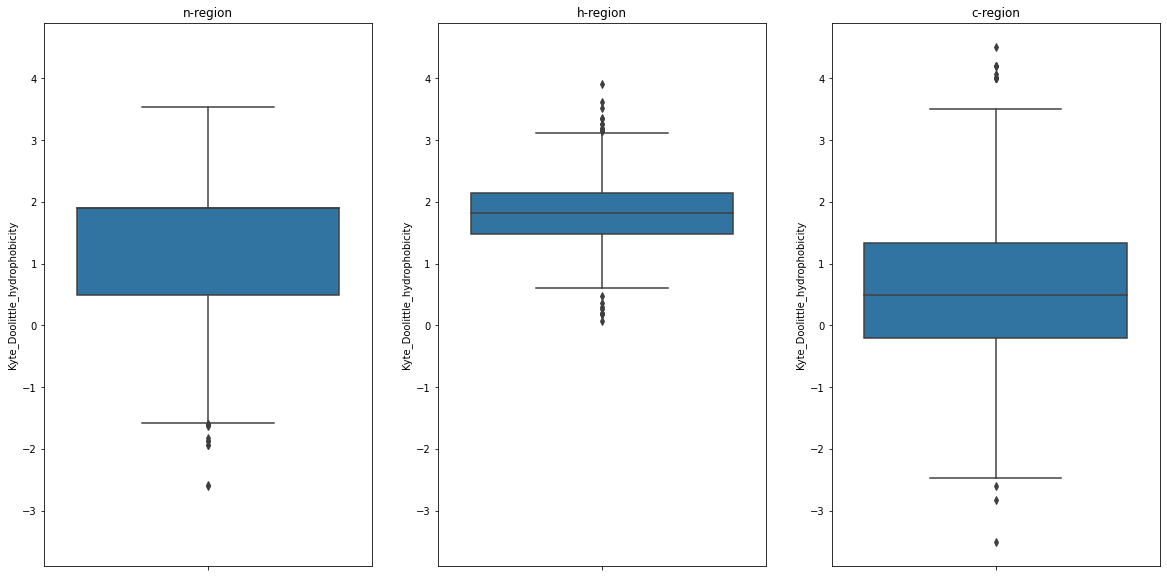

In [33]:
plt.figure(figsize=(20,10))

ax1 = plt.subplot(1,3,1)
ax1 = sns.boxplot(y=n_region["Kyte_Doolittle_hydrophobicity"], orient='vertical')


plt.title('n-region')
ax2 = plt.subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2 = sns.boxplot(y=h_region["Kyte_Doolittle_hydrophobicity"], orient='Vertical')

plt.title('h-region')
ax3 = plt.subplot(1,3,3, sharex=ax1, sharey=ax1)

ax3 = sns.boxplot(y=c_region["Kyte_Doolittle_hydrophobicity"], orient='Vertical')
plt.title('c-region')



Text(0.5, 1.0, 'c-region')

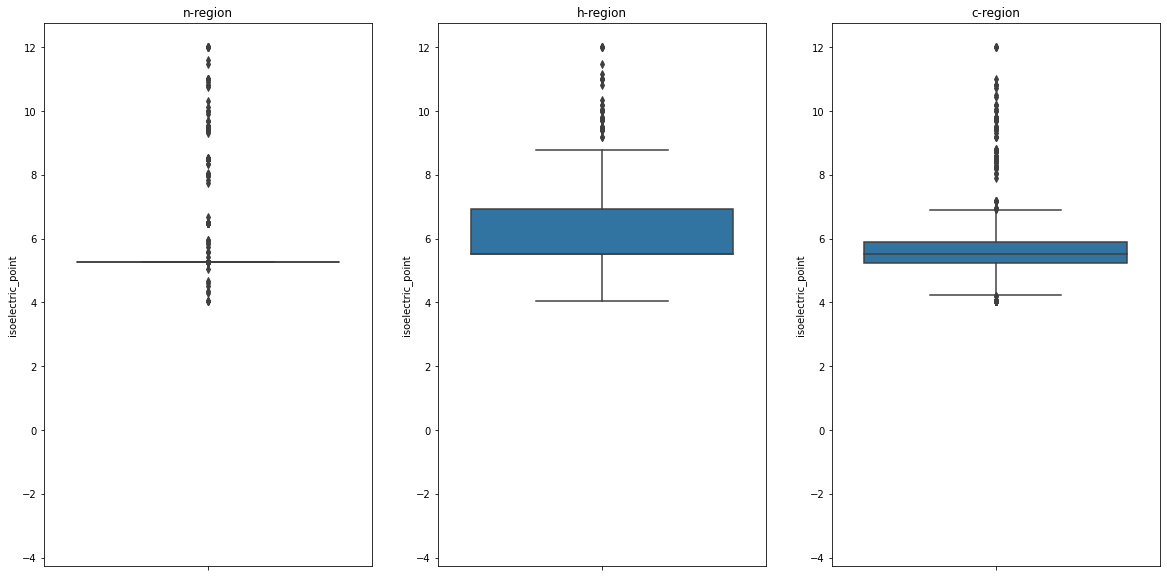

In [34]:

plt.figure(figsize=(20,10))
ax1 = plt.subplot(1,3,1, sharex=ax1, sharey=ax1)
ax1 = sns.boxplot(y=n_region["isoelectric_point"], orient='vertical')


plt.title('n-region')
ax2 = plt.subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2 = sns.boxplot(y=h_region["isoelectric_point"], orient='Vertical')

plt.title('h-region')
ax3 = plt.subplot(1,3,3, sharex=ax1, sharey=ax1)

ax3 = sns.boxplot(y=c_region["isoelectric_point"], orient='Vertical')
plt.title('c-region')


Text(0.5, 1.0, 'c-region')

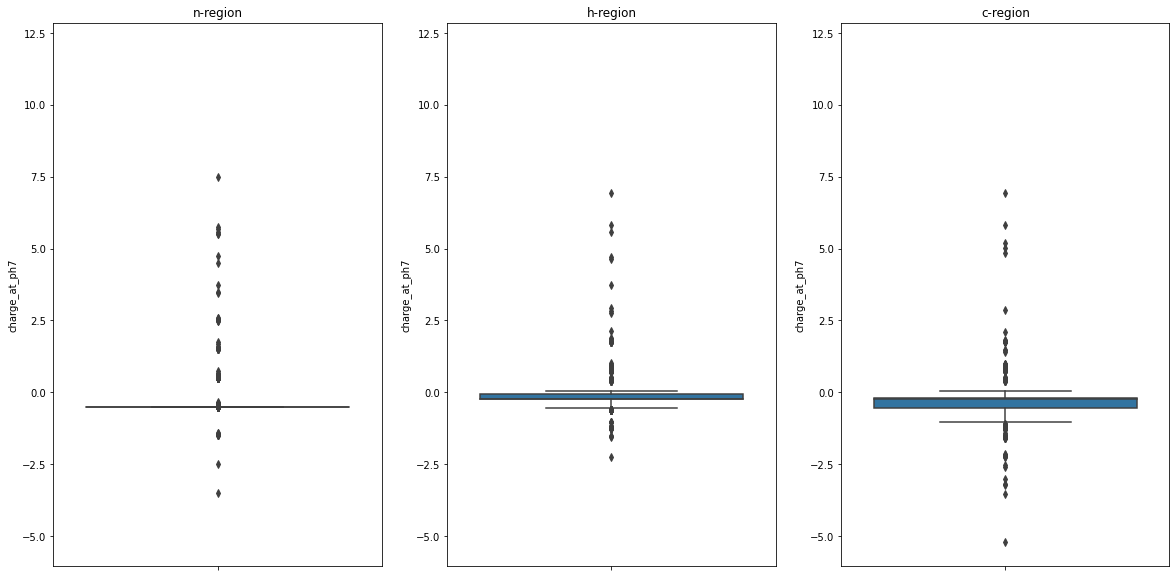

In [35]:

plt.figure(figsize=(20,10))
ax1 = plt.subplot(1,3,1, sharex=ax1, sharey=ax1)
ax1 = sns.boxplot(y=n_region["charge_at_ph7"], orient='vertical')


plt.title('n-region')
ax2 = plt.subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2 = sns.boxplot(y=h_region["charge_at_ph7"], orient='Vertical')

plt.title('h-region')
ax3 = plt.subplot(1,3,3, sharex=ax1, sharey=ax1)

ax3 = sns.boxplot(y=c_region["charge_at_ph7"], orient='Vertical')
plt.title('c-region')


## Consensus sequence

ok so the following only works if you use the same length of sequences so we have to trim them. Not a fan of trimming. we will have to find a way around this: 

In [36]:
instances = []

for sp in list_of_SPs: 
    if len(sp) > 20: 
        instances.append(Seq(sp[:20]))
    else: 
        continue

In [37]:
from Bio import motifs

m = motifs.create(instances, alphabet="ACDEFGHIKLMNPQRSTVWY")
m.consensus

Seq('MKLSSLLLLLLLLLLLLALA')

In [38]:
print(m.counts)
df = pd.DataFrame(m.counts)

        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19
A:   0.00  50.00  22.00  21.00  25.00  34.00  35.00  35.00  70.00  80.00  83.00  83.00  98.00  77.00  89.00  82.00  97.00  95.00  78.00  76.00
C:   0.00   2.00   2.00   1.00   3.00   8.00  14.00   5.00   8.00   7.00  11.00  13.00   7.00  13.00  10.00  11.00  13.00  11.00  11.00   5.00
D:   0.00   3.00   6.00   5.00   3.00   5.00   2.00   6.00   2.00   1.00   2.00   0.00   0.00   2.00   3.00   2.00   3.00   5.00   5.00   6.00
E:   0.00   2.00   7.00   3.00   4.00   2.00   1.00   5.00   5.00   0.00   2.00   1.00   2.00   2.00   1.00   0.00   1.00   1.00   1.00   2.00
F:   0.00  14.00  65.00  46.00  29.00  33.00  40.00  29.00  29.00  27.00  28.00  25.00  26.00  26.00  20.00  29.00  33.00  26.00  25.00  11.00
G:   0.00  18.00  28.00  12.00  14.00  14.00  21.00  15.00  21.00  24.00  20.00  13.00  26.00  32.00  18.00  28.00  26.00  31.00  25.00  27.00

In [39]:
df

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0,0,0,0,0,0,0,0,0,0,469,0,0,0,0,0,0,0,0,0
1,50,2,3,2,14,18,29,17,80,31,10,10,19,22,71,24,11,35,10,11
2,22,2,6,7,65,28,14,27,9,77,9,14,26,9,26,68,24,17,9,10
3,21,1,5,3,46,12,7,25,30,68,5,17,24,18,34,77,48,9,3,16
4,25,3,3,4,29,14,8,36,28,52,12,27,20,18,30,77,47,17,7,12
5,34,8,5,2,33,14,8,37,18,81,8,7,25,15,22,72,40,20,7,13
6,35,14,2,1,40,21,10,36,16,111,11,4,17,8,23,44,24,34,8,10
7,35,5,6,5,29,15,4,33,13,105,5,8,17,12,25,50,50,34,10,8
8,70,8,2,5,29,21,6,29,6,112,10,5,17,6,25,45,25,36,7,5
9,80,7,1,0,27,24,5,18,8,144,6,5,10,7,16,35,23,39,5,9


In [40]:
df_pwn = pd.DataFrame(m.pwm)
df_pwn

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.106610,0.004264,0.006397,0.004264,0.029851,0.038380,0.061834,0.036247,0.170576,0.066098,0.021322,0.021322,0.040512,0.046908,0.151386,0.051173,0.023454,0.074627,0.021322,0.023454
2,0.046908,0.004264,0.012793,0.014925,0.138593,0.059701,0.029851,0.057569,0.019190,0.164179,0.019190,0.029851,0.055437,0.019190,0.055437,0.144989,0.051173,0.036247,0.019190,0.021322
3,0.044776,0.002132,0.010661,0.006397,0.098081,0.025586,0.014925,0.053305,0.063966,0.144989,0.010661,0.036247,0.051173,0.038380,0.072495,0.164179,0.102345,0.019190,0.006397,0.034115
4,0.053305,0.006397,0.006397,0.008529,0.061834,0.029851,0.017058,0.076759,0.059701,0.110874,0.025586,0.057569,0.042644,0.038380,0.063966,0.164179,0.100213,0.036247,0.014925,0.025586
5,0.072495,0.017058,0.010661,0.004264,0.070362,0.029851,0.017058,0.078891,0.038380,0.172708,0.017058,0.014925,0.053305,0.031983,0.046908,0.153518,0.085288,0.042644,0.014925,0.027719
6,0.074627,0.029851,0.004264,0.002132,0.085288,0.044776,0.021322,0.076759,0.034115,0.236674,0.023454,0.008529,0.036247,0.017058,0.049041,0.093817,0.051173,0.072495,0.017058,0.021322
7,0.074627,0.010661,0.012793,0.010661,0.061834,0.031983,0.008529,0.070362,0.027719,0.223881,0.010661,0.017058,0.036247,0.025586,0.053305,0.106610,0.106610,0.072495,0.021322,0.017058
8,0.149254,0.017058,0.004264,0.010661,0.061834,0.044776,0.012793,0.061834,0.012793,0.238806,0.021322,0.010661,0.036247,0.012793,0.053305,0.095949,0.053305,0.076759,0.014925,0.010661
9,0.170576,0.014925,0.002132,0.000000,0.057569,0.051173,0.010661,0.038380,0.017058,0.307036,0.012793,0.010661,0.021322,0.014925,0.034115,0.074627,0.049041,0.083156,0.010661,0.019190


In [41]:
import logomaker as lm

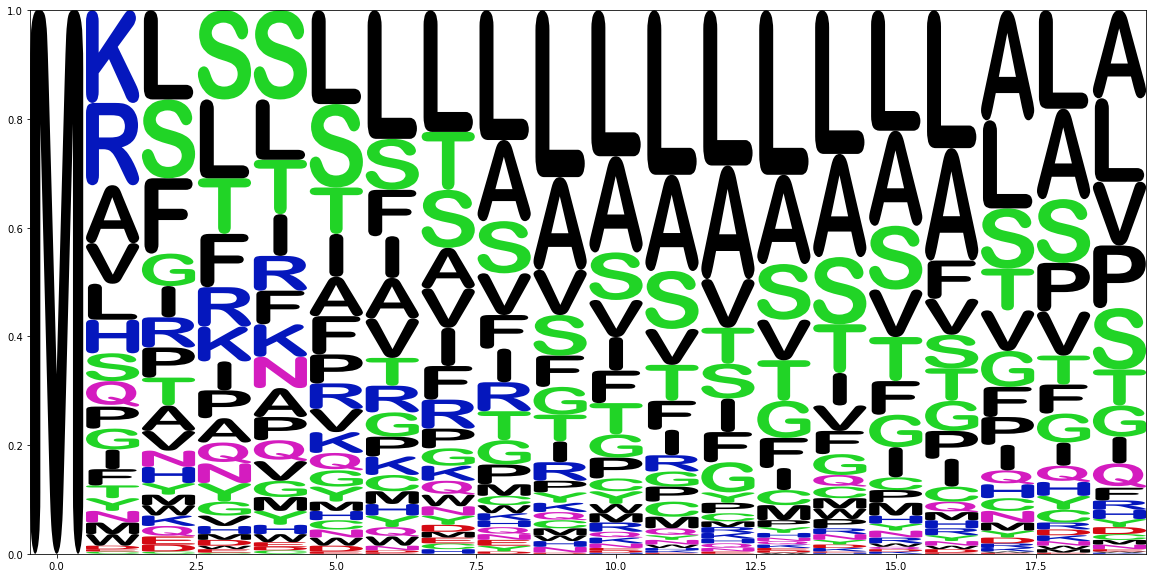

In [42]:
logo = lm.Logo(df_pwn, 
               font_name = 'Arial Rounded MT Bold', 
               figsize=(20,10))

In [43]:
df_pwn

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.106610,0.004264,0.006397,0.004264,0.029851,0.038380,0.061834,0.036247,0.170576,0.066098,0.021322,0.021322,0.040512,0.046908,0.151386,0.051173,0.023454,0.074627,0.021322,0.023454
2,0.046908,0.004264,0.012793,0.014925,0.138593,0.059701,0.029851,0.057569,0.019190,0.164179,0.019190,0.029851,0.055437,0.019190,0.055437,0.144989,0.051173,0.036247,0.019190,0.021322
3,0.044776,0.002132,0.010661,0.006397,0.098081,0.025586,0.014925,0.053305,0.063966,0.144989,0.010661,0.036247,0.051173,0.038380,0.072495,0.164179,0.102345,0.019190,0.006397,0.034115
4,0.053305,0.006397,0.006397,0.008529,0.061834,0.029851,0.017058,0.076759,0.059701,0.110874,0.025586,0.057569,0.042644,0.038380,0.063966,0.164179,0.100213,0.036247,0.014925,0.025586
5,0.072495,0.017058,0.010661,0.004264,0.070362,0.029851,0.017058,0.078891,0.038380,0.172708,0.017058,0.014925,0.053305,0.031983,0.046908,0.153518,0.085288,0.042644,0.014925,0.027719
6,0.074627,0.029851,0.004264,0.002132,0.085288,0.044776,0.021322,0.076759,0.034115,0.236674,0.023454,0.008529,0.036247,0.017058,0.049041,0.093817,0.051173,0.072495,0.017058,0.021322
7,0.074627,0.010661,0.012793,0.010661,0.061834,0.031983,0.008529,0.070362,0.027719,0.223881,0.010661,0.017058,0.036247,0.025586,0.053305,0.106610,0.106610,0.072495,0.021322,0.017058
8,0.149254,0.017058,0.004264,0.010661,0.061834,0.044776,0.012793,0.061834,0.012793,0.238806,0.021322,0.010661,0.036247,0.012793,0.053305,0.095949,0.053305,0.076759,0.014925,0.010661
9,0.170576,0.014925,0.002132,0.000000,0.057569,0.051173,0.010661,0.038380,0.017058,0.307036,0.012793,0.010661,0.021322,0.014925,0.034115,0.074627,0.049041,0.083156,0.010661,0.019190


In [44]:
transposed = df_pwn.T

list_of_top_aa_per_position= []
for column in transposed.columns[1:]:
    print(str(transposed[column].nlargest(4)))
    
    # calculate the largest 
    largest = float(pd.DataFrame(transposed[column].nlargest(1)).reset_index().iloc[:,-1])
    #
    #if largest > 0.3: 
    #    position_df = pd.DataFrame(transposed[column].nlargest(1)).reset_index()
    #    list_of_aa = list(position_df['index'])
    #    list_of_top_aa_per_position.append(list_of_aa)
        
    
    if largest > 0.25: 
        position_df = pd.DataFrame(transposed[column].nlargest(2)).reset_index()
        list_of_aa = list(position_df['index'])
        list_of_top_aa_per_position.append(list_of_aa)
    
    #if largest > 0.20: 
    #    position_df = pd.DataFrame(transposed[column].nlargest(3)).reset_index()
    #    list_of_aa = list(position_df['index'])
    #    list_of_top_aa_per_position.append(list_of_aa)
    #    
        
    else: 
        position_df = pd.DataFrame(transposed[column].nlargest(3)).reset_index()
        list_of_aa = list(position_df['index'])
        list_of_top_aa_per_position.append(list_of_aa)
list_of_top_aa_per_position

K    0.170576
R    0.151386
A    0.106610
V    0.074627
Name: 1, dtype: float64
L    0.164179
S    0.144989
F    0.138593
G    0.059701
Name: 2, dtype: float64
S    0.164179
L    0.144989
T    0.102345
F    0.098081
Name: 3, dtype: float64
S    0.164179
L    0.110874
T    0.100213
I    0.076759
Name: 4, dtype: float64
L    0.172708
S    0.153518
T    0.085288
I    0.078891
Name: 5, dtype: float64
L    0.236674
S    0.093817
F    0.085288
I    0.076759
Name: 6, dtype: float64
L    0.223881
S    0.106610
T    0.106610
A    0.074627
Name: 7, dtype: float64
L    0.238806
A    0.149254
S    0.095949
V    0.076759
Name: 8, dtype: float64
L    0.307036
A    0.170576
V    0.083156
S    0.074627
Name: 9, dtype: float64
L    0.268657
A    0.176972
S    0.087420
V    0.068230
Name: 10, dtype: float64
L    0.302772
A    0.176972
S    0.106610
T    0.066098
Name: 11, dtype: float64
L    0.285714
A    0.208955
V    0.089552
T    0.066098
Name: 12, dtype: float64
L    0.302772
A    0.164179
S    0.10

[['K', 'R', 'A'],
 ['L', 'S', 'F'],
 ['S', 'L', 'T'],
 ['S', 'L', 'T'],
 ['L', 'S', 'T'],
 ['L', 'S', 'F'],
 ['L', 'S', 'T'],
 ['L', 'A', 'S'],
 ['L', 'A'],
 ['L', 'A'],
 ['L', 'A'],
 ['L', 'A'],
 ['L', 'A'],
 ['L', 'A'],
 ['L', 'A', 'S'],
 ['L', 'A'],
 ['A', 'L', 'S'],
 ['L', 'A', 'S'],
 ['A', 'L', 'V']]

In [45]:
len(list_of_top_aa_per_position)

19

In [46]:
from itertools import product

In [47]:
#%%time
#all_combinations = list(product(*list_of_top_aa_per_position))
#column_names = [i for i in range(1,20)]
#df_all_combinations = pd.DataFrame(all_combinations, columns = column_names)
#df_all_combinations[0] = 'M'
#df_all_combinations_with_M = df_all_combinations[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]]
#df_all_combinations_with_M.to_csv('../data/all_signal_peptides/combinations_of_2_3_SPs.csv')

In [53]:
%%time
df_with_all_combinations = pd.read_csv('../data/02_All_signal_peptides/combinations_of_2_3_SPs.csv')

CPU times: user 1min 13s, sys: 30.7 s, total: 1min 43s
Wall time: 1min 55s


In [58]:
df_with_all_combinations

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,0,M,K,L,S,S,L,L,L,L,...,L,L,L,L,L,L,L,A,L,A
1,1,M,K,L,S,S,L,L,L,L,...,L,L,L,L,L,L,L,A,L,L
2,2,M,K,L,S,S,L,L,L,L,...,L,L,L,L,L,L,L,A,L,V
3,3,M,K,L,S,S,L,L,L,L,...,L,L,L,L,L,L,L,A,A,A
4,4,M,K,L,S,S,L,L,L,L,...,L,L,L,L,L,L,L,A,A,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68024443,68024443,M,A,F,T,T,T,F,T,S,...,A,A,A,A,A,S,A,S,A,L
68024444,68024444,M,A,F,T,T,T,F,T,S,...,A,A,A,A,A,S,A,S,A,V
68024445,68024445,M,A,F,T,T,T,F,T,S,...,A,A,A,A,A,S,A,S,S,A
68024446,68024446,M,A,F,T,T,T,F,T,S,...,A,A,A,A,A,S,A,S,S,L


In [55]:
data_points = []
index = []

for i in range(1,19): 
    data_points.append(3**i)
    index.append(i)

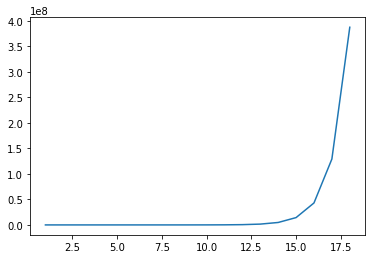

In [56]:
import matplotlib.pyplot as plt
plt.plot(index, data_points)
plt.show()

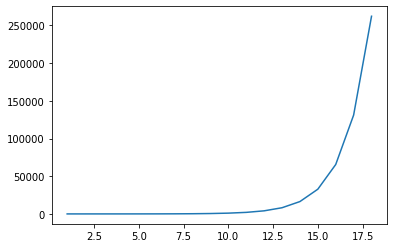

In [57]:
data_points = []
index = []

for i in range(1,19): 
    data_points.append(2**i)
    index.append(i)
    
plt.plot(index, data_points)
plt.show()